**Image analysis with python code**
Image analysis of microscopy images could be performed by means of ImageJ software.
However, this process could be time-consuming because the process is made step by step by the user and it is not so easy to distinguish between particles and matrix during threshold step. This is due to a similar gray scale between these phases, therefore, it is complex to define edges of particles.

The main aims of the following python code are:
1. obtaining automatically a clear distinction between particles and matrix;
2. the extraction of particles measurements like areas, equivalent diammeters and perimeters in excel files;
3. data elaboration of the measurements

-	Import all the necessary libraries to run the code

In [1]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv_imshow
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import io, color, measure

-	Set the scale in order to convert measures from pixels unit into µm

In [2]:
pixels_to_um=0.0145

-	Upload the original image and visualize it with its dimensions (height, width, channel)

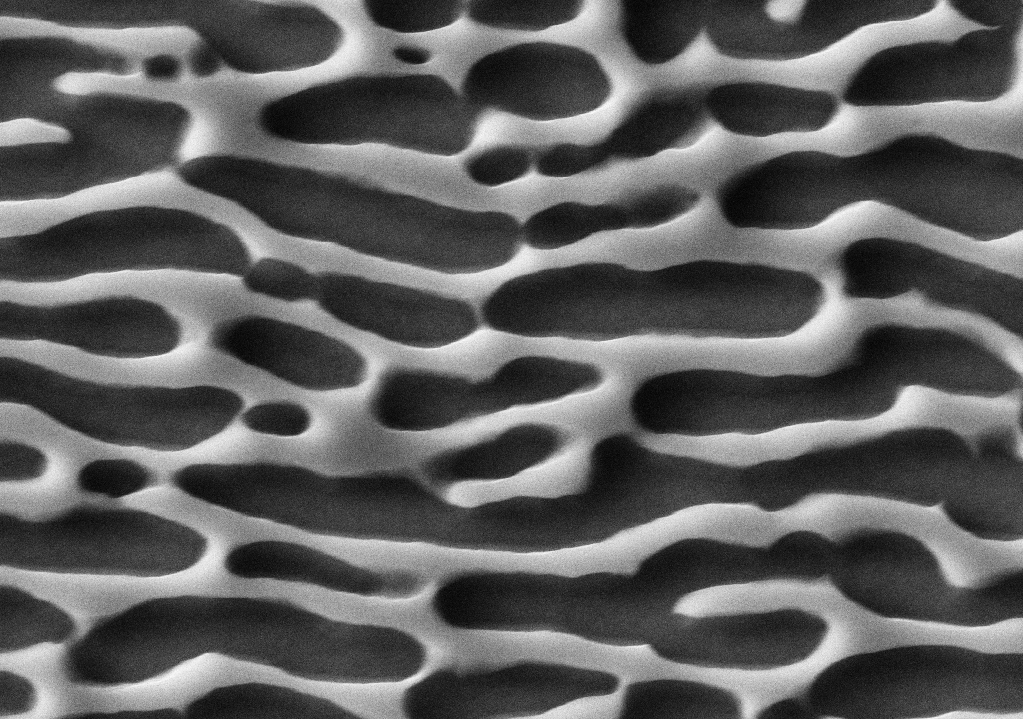

(720, 1023, 3)


In [3]:
img=cv.imread('/content/Images/Sample1.tif')
cv_imshow(img)

img=np.array(img)
print(img.shape)

-	Transform the original image in gray scale

In [4]:
img=cv.imread('/content/Images/Sample1.tif',0)
img=np.array(img)
print(img.shape)

(720, 1023)


- Convert the area of the image in µm

In [5]:
area_img_um=(720*pixels_to_um)*(1023*pixels_to_um)
print(area_img_um)

154.86174000000003


-	Threshold histogram

(array([7.0000e+00, 8.7000e+01, 2.8400e+02, 1.2640e+03, 1.7680e+03,
        4.1920e+03, 4.0990e+03, 8.6950e+03, 7.4960e+03, 1.3879e+04,
        1.7571e+04, 1.3310e+04, 2.2542e+04, 1.5757e+04, 2.4985e+04,
        1.7028e+04, 2.6127e+04, 1.7736e+04, 2.6609e+04, 1.7850e+04,
        2.5763e+04, 2.5160e+04, 1.6001e+04, 2.2462e+04, 1.3547e+04,
        1.8336e+04, 1.0471e+04, 1.3518e+04, 7.6760e+03, 9.7330e+03,
        7.8880e+03, 4.5250e+03, 6.0340e+03, 3.6650e+03, 5.0640e+03,
        3.0910e+03, 4.6440e+03, 2.9830e+03, 4.3510e+03, 2.9460e+03,
        4.4360e+03, 4.4620e+03, 3.1230e+03, 4.5480e+03, 3.2680e+03,
        5.0150e+03, 3.5080e+03, 5.5100e+03, 3.8800e+03, 6.2240e+03,
        6.6060e+03, 4.8550e+03, 7.4320e+03, 5.2140e+03, 8.1280e+03,
        5.8320e+03, 9.1670e+03, 6.1540e+03, 9.6630e+03, 6.6220e+03,
        9.8100e+03, 9.8130e+03, 6.4780e+03, 9.5620e+03, 6.3330e+03,
        9.5520e+03, 6.1100e+03, 9.0490e+03, 5.8540e+03, 8.2880e+03,
        7.8540e+03, 5.2910e+03, 7.3570e+03, 4.73

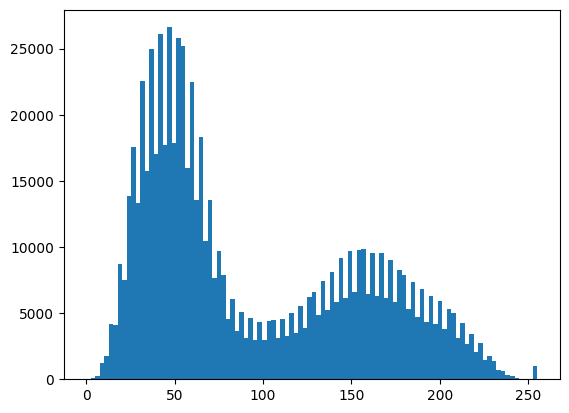

In [6]:
plt.hist(img.flat,bins=100,range=(0,255))

- OTSU's method in order to threshold the image and transform into a binary image

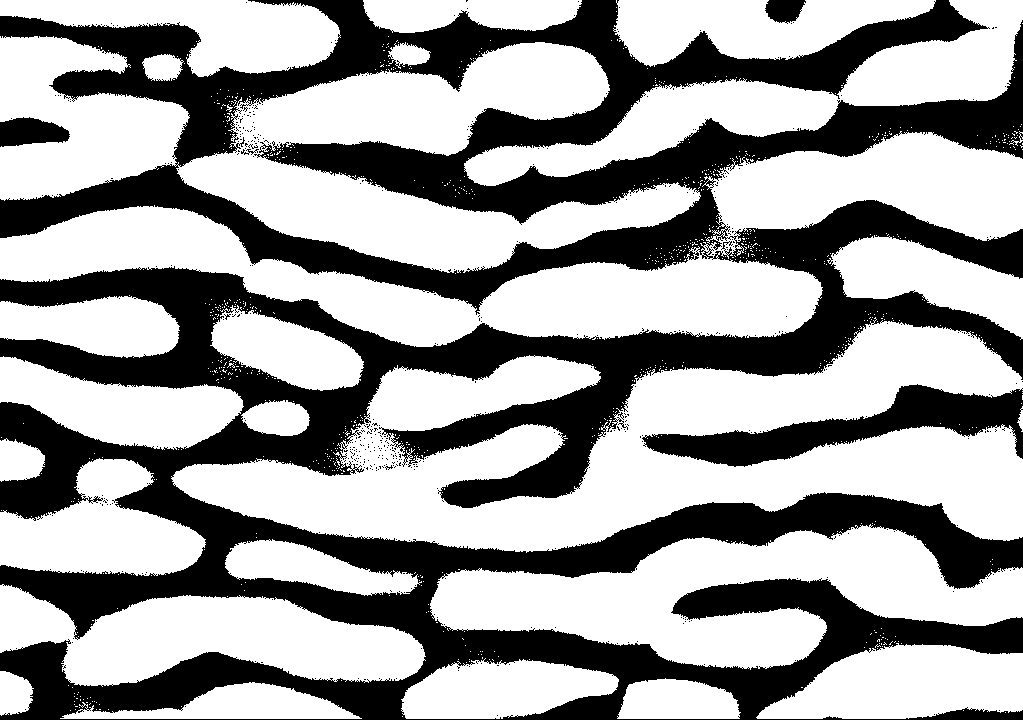

In [7]:
ret, th = cv.threshold(img,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
cv_imshow(th)

-	Opening method (Dilation followed by erosion in order to remove noises around particles)

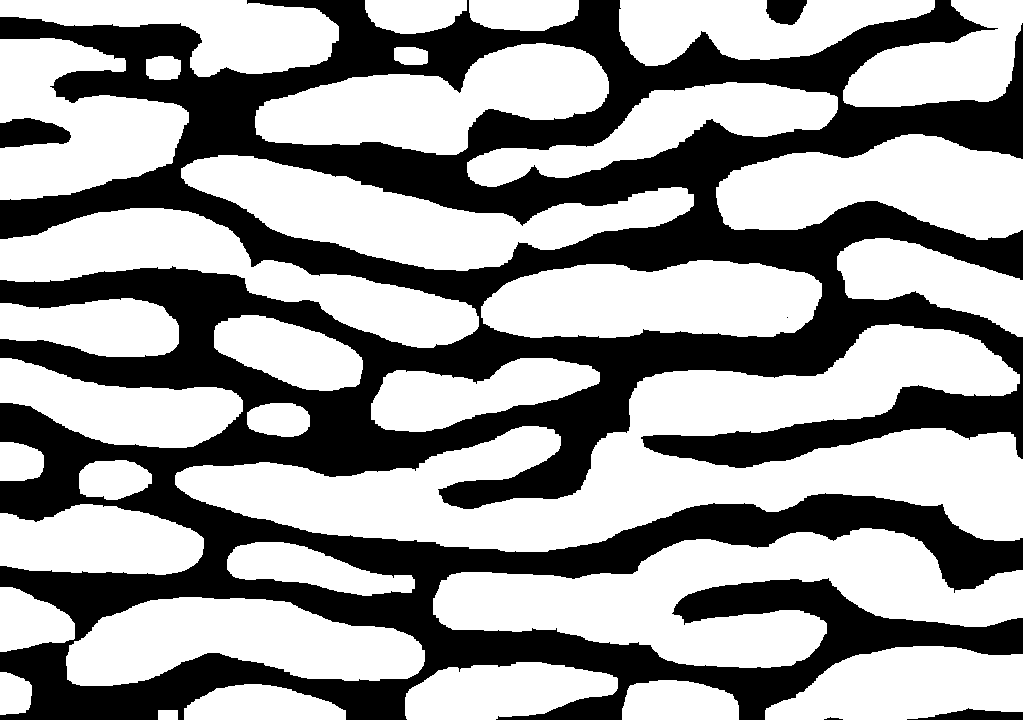

In [8]:
kernel=np.ones((10,10),np.uint8)
opening=cv.morphologyEx(th,cv.MORPH_OPEN,kernel,iterations=1)
cv_imshow(opening)


Start segmentation process

-	Individuate sure background (for segmentation process). With the dilation process it is possible to expand particles (white colored) in order to individuate areas that for sure do not contain particles (black regions correspond to the matrix)

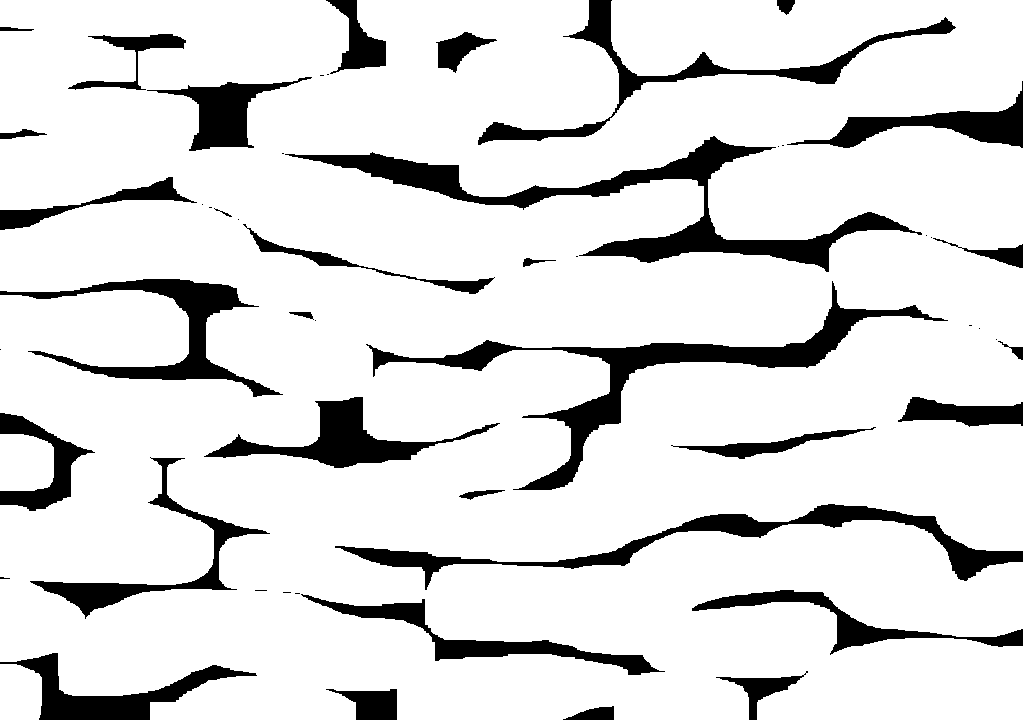

In [9]:
sure_bg = cv.dilate(opening,kernel,iterations=2)
cv_imshow(sure_bg)



-	Definition of distance transform to establish the sure foreground (for segmentation process). The aim of this step is to individuate the center of each particle



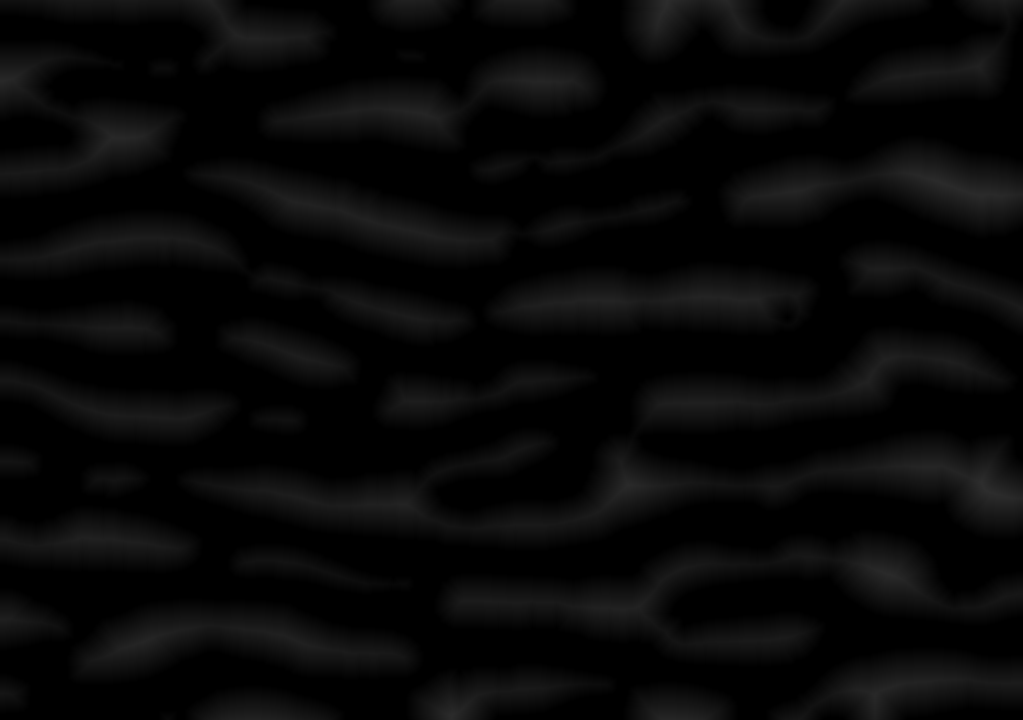

In [10]:
dist_transform=cv.distanceTransform(opening,cv.DIST_L2,3)
cv_imshow(dist_transform)


-	Sure foreground (for segmentation process). Individuation of regions that belong to particles for sure, in particular white regions represent particle seeds

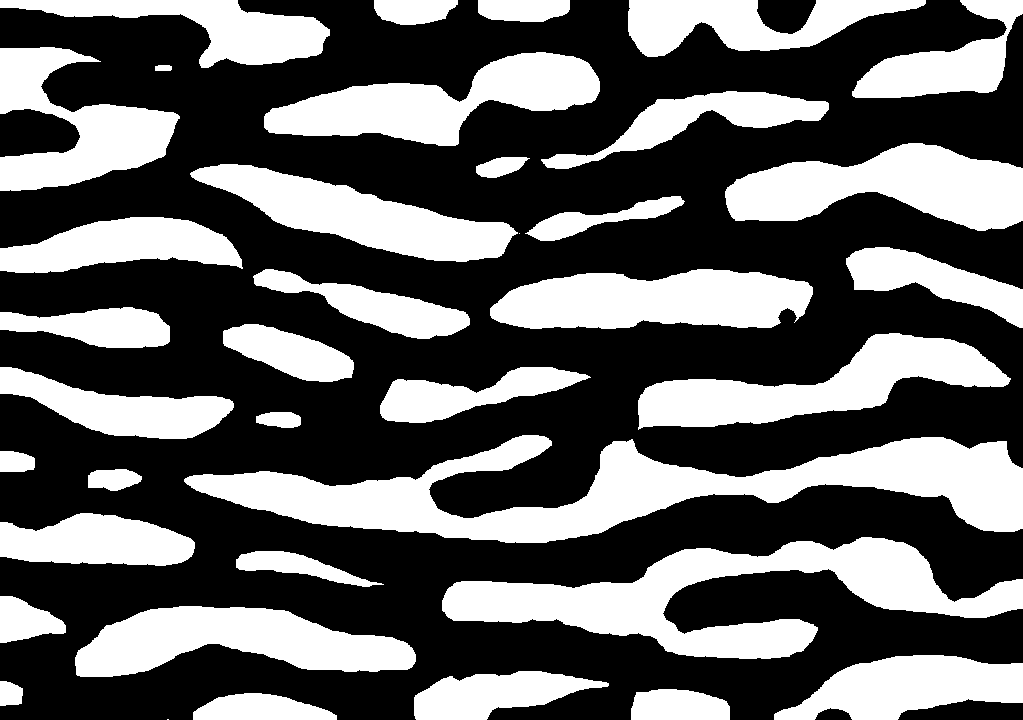

In [11]:
ret2,sure_fg = cv.threshold(dist_transform,0.19*dist_transform.max(),255,0)
sure_fg=np.uint8(sure_fg)
cv_imshow(sure_fg)


-	Unknown regions (for segmentation process). Individuation of regions which are uncertain if they belong to the background (matrix) or to the foreground (particles)

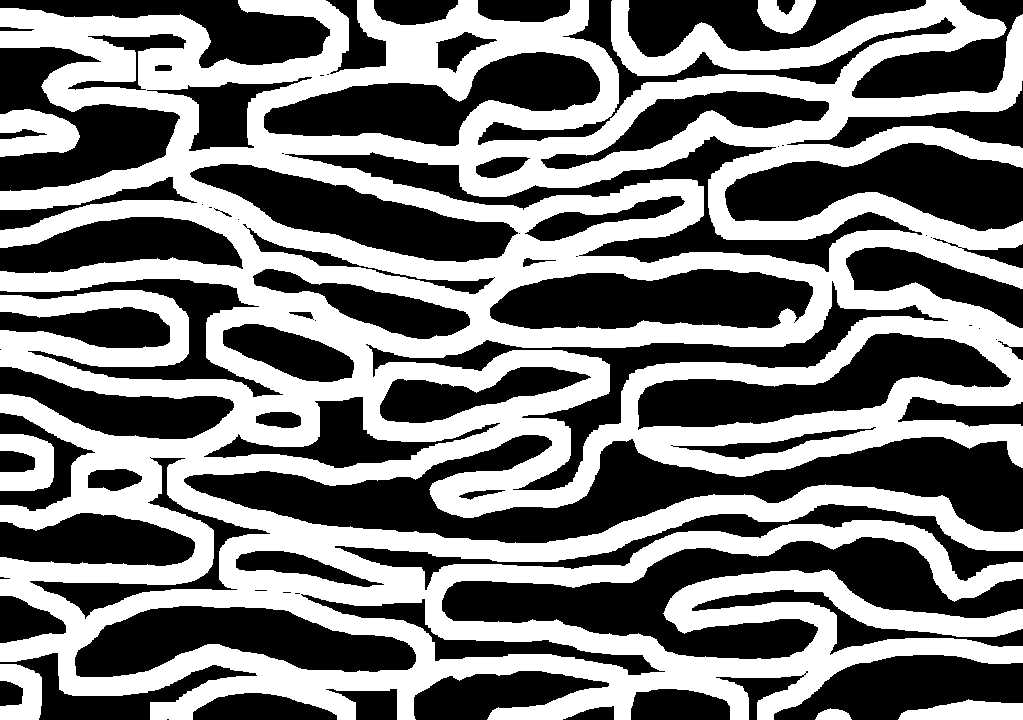

In [12]:
unknown = cv.subtract(sure_bg,sure_fg)
cv_imshow(unknown)


-	Application of Watershed segmentation. Each particle is associated to a marker.
The following plot shows:
1. Colored regions = sure foreground
2. Blue regions = sure backgroun
3. Dark blue regions that surround particles = unknown regions

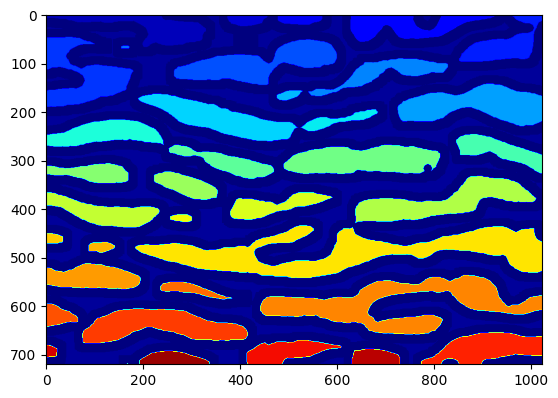

In [22]:
ret3, markers = cv.connectedComponents(sure_fg)
markers=markers+1
markers[unknown==255]=0
plt.imshow(markers,cmap='jet')


-	Application of watershed algorithm and visualization of the segmented image

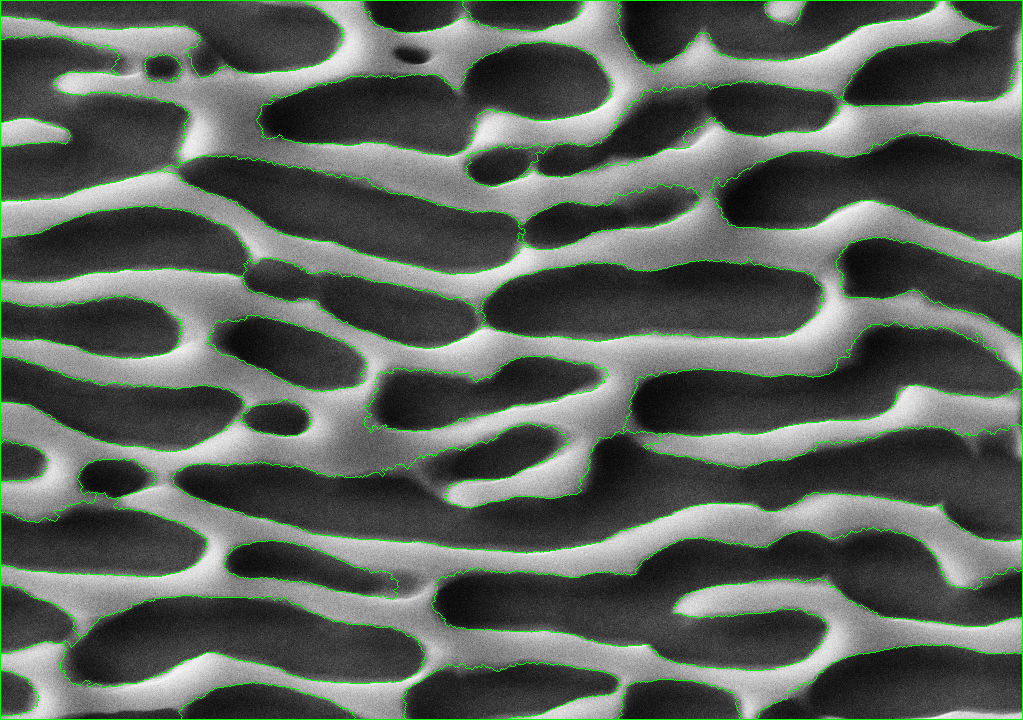

In [23]:
img1 = cv.imread('/content/Images/Sample1.tif')
cv.watershed(img1,markers)
img1[markers==-1]=[0,255,0]
img2=color.label2rgb(markers,bg_label=0)
cv_imshow(img1)

-	Extraction of properties from the segmented image (areas, equivalent diameters and perimeters of the particles) in pixels units in a csv file

In [38]:
from skimage import measure, color
import pandas as pd

p = ['label', 'area', 'equivalent_diameter', 'perimeter']
props = measure.regionprops_table(markers, img, properties=p)
df = pd.DataFrame(props)

print (df)
df.to_csv('img_data_pixel.csv')

    label    area  equivalent_diameter     perimeter
0       1  271036           587.446809  22115.759364
1       2   13985           133.440080    849.144228
2       3    2582            57.336764    266.681241
3       4    2814            59.857298    286.095454
4       5   12883           128.074764    833.434596
5       6   11481           120.905183    621.587878
6       7   19678           158.287105   1008.039718
7       8   21868           166.862825    962.702669
8       9     763            31.168602    122.953319
9      10   12831           127.816026    899.993037
10     11   21281           164.608052    870.891486
11     12    2079            51.449636    244.977705
12     13   20003           159.588880    945.614357
13     14    5760            85.637958    478.392965
14     15   13358           130.414469    645.043723
15     16      30             6.180387     20.899495
16     17    9522           110.108069    559.606168
17     18   10079           113.282750    654.

- Transformation of the above results in µm units and save into csv and xlsx file

In [51]:
file_path = '/content/img_data_pixel.csv'
df = pd.read_csv(file_path)

column_area = 'area'
column_equivalent_diameter= 'equivalent_diameter'
column_perimeter= 'perimeter'
scalar1 = 0.0145
scalar2 = 0.0145*0.0145

df[column_area] = df[column_area] * scalar2
df[column_equivalent_diameter] = df[column_equivalent_diameter] * scalar1
df[column_perimeter] = df[column_perimeter] * scalar1

df.to_csv('img_data_um.csv', encoding="utf-8",index=False)

df.to_excel("img_data_um.xlsx", sheet_name="measurements_Sample1",index=False)

- Eliminate the first line that corresponds to measurements of the matrix

In [52]:
df = df.drop(0)
print (df)
df.to_csv('img_data_um.csv')

    Unnamed: 0  label       area  equivalent_diameter  perimeter
1            1      2   2.940346             1.934881  12.312591
2            2      3   0.542866             0.831383   3.866878
3            3      4   0.591643             0.867931   4.148384
4            4      5   2.708651             1.857084  12.084802
5            5      6   2.413880             1.753125   9.013024
6            6      7   4.137300             2.295163  14.616576
7            7      8   4.597747             2.419511  13.959189
8            8      9   0.160421             0.451945   1.782823
9            9     10   2.697718             1.853332  13.049899
10          10     11   4.474330             2.386817  12.627927
11          11     12   0.437110             0.746020   3.552177
12          12     13   4.205631             2.314039  13.711408
13          13     14   1.211040             1.241750   6.936698
14          14     15   2.808520             1.891010   9.353134
15          15     16   0

- Sum the values of particles areas

In [53]:
df = pd.read_csv('img_data_um.csv')
column_to_sum = 'area'
sum = df[column_to_sum].sum()
print(sum)

93.36214324999997


- Particles volume fraction

In [54]:
volume_fraction=sum/area_img_um
print(volume_fraction)

0.6028741718257845


 - Particles size distribution (histogram)

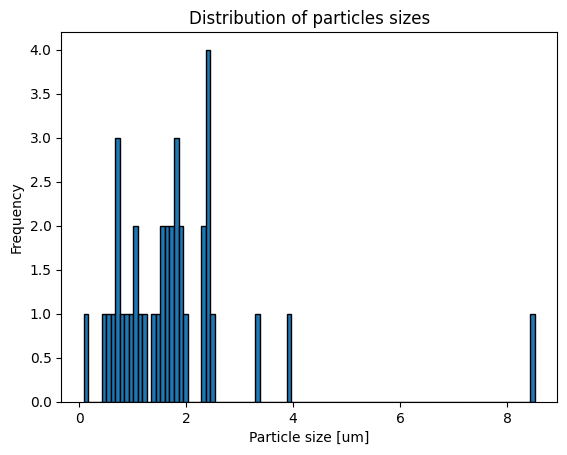

In [59]:
df_dati = pd.read_excel('/content/img_data_um.xlsx')
df_classi = pd.read_excel('/content/Classi.xlsx')

df = pd.concat([df_dati, df_classi], axis=1)

plt.hist(df['equivalent_diameter'], bins=100, edgecolor='k')
plt.xlabel('Particle size [um]')
plt.ylabel('Frequency')
plt.title('Distribution of particles sizes')
plt.show()